In [ ]:
import pandas as pd
df = pd.read_csv("data.csv")
df.drop("Unnamed: 0", inplace=True, axis=1)
print(df.head())

    X1   X2   X3   X4   X5   X6   X7  ...  X173  X174  X175  X176  X177  X178  y
0  135  190  229  223  192  125   55  ...   -77  -103  -127  -116   -83   -51  4
1  386  382  356  331  320  315  307  ...   152   157   156   154   143   129  1
2  -32  -39  -47  -37  -32  -36  -57  ...    19   -12   -30   -35   -35   -36  5
3 -105 -101  -96  -92  -89  -95 -102  ...   -77   -85   -77   -72   -69   -65  5
4   -9  -65  -98 -102  -78  -48  -16  ...   -32   -41   -65   -83   -89   -73  5

[5 rows x 179 columns]


In [ ]:
from sklearn.model_selection import train_test_split
Y = {2:0, 3:0, 4:0, 5:0, 1:1}
df.y = [Y[i] for i in df.y]
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
x_train , x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
def create_dataset(X):
  X = X.reshape(X.shape[0], 1, X.shape[1])
  return X
x_train = create_dataset(x_train)
x_test = create_dataset(x_test)
print(x_train.shape)
print(x_test.shape)


(8625, 1, 178)
(2875, 1, 178)


Inception Architecture


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate,Conv1D,Dense,MaxPooling1D,Flatten,Input,Dropout
from tensorflow.keras.utils import plot_model
def inception_module(input, f1, f2):
  layer1 = Conv1D(1, 1, padding="same", activation="relu")(input)
  layer2 = Conv1D(1, 1, padding="same", activation="relu")(input)
  pool = MaxPooling1D(1, padding="same")(input)
  layer3 = Conv1D(f1, 1, padding="same", activation="relu")(layer1)
  layer4 = Conv1D(f2, 1, padding="same", activation="relu")(layer2)
  layer5 = Conv1D(1, 1, padding="same", activation="relu")(pool)
  layer6 = Conv1D(1, 1, padding="same", activation="relu")(input)
  con = concatenate([layer3, layer4, layer5, layer6], axis=-1)
  return con
input_layer = Input((x_train.shape[1],x_train.shape[2]))
layer = inception_module(input_layer, 16, 32)
layer = inception_module(layer, 32, 64)
layer7 = Flatten()(layer)
output = Dense(1, activation="sigmoid")(layer7)
model = Model(inputs=input_layer, outputs=output)
print(model.summary())
model.compile(optimizer="Adam", loss= "binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=15, verbose=True, validation_split=0.2, batch_size=32)
test_loss, test_acc=model.evaluate(x_test, y_test)
print(test_acc)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1, 178)]     0                                            
__________________________________________________________________________________________________
conv1d_90 (Conv1D)              (None, 1, 1)         179         input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_91 (Conv1D)              (None, 1, 1)         179         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_10 (MaxPooling1D) (None, 1, 178)       0           input_8[0][0]                    
___________________________________________________________________________________________

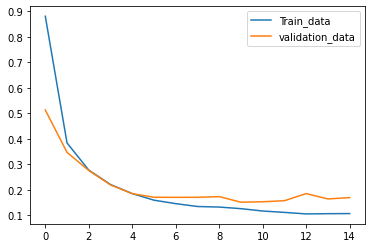

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Train_data")
plt.plot(history.history["val_loss"], label="validation_data")
plt.legend()
plt.show()

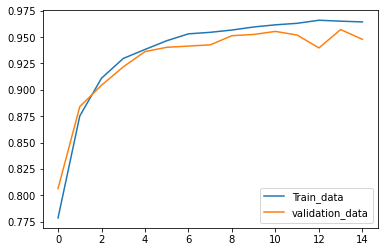

In [ ]:
plt.plot(history.history["accuracy"], label="Train_data")
plt.plot(history.history["val_accuracy"], label="validation_data")
plt.legend()
plt.show()

In [ ]:
y_pred_inception = model.predict(x_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, y_pred_inception)
area = auc(fpr, tpr)
print(y_test[2657], y_pred_inception[2657].round())
print(area)

1 [1.]
0.9781059229314245


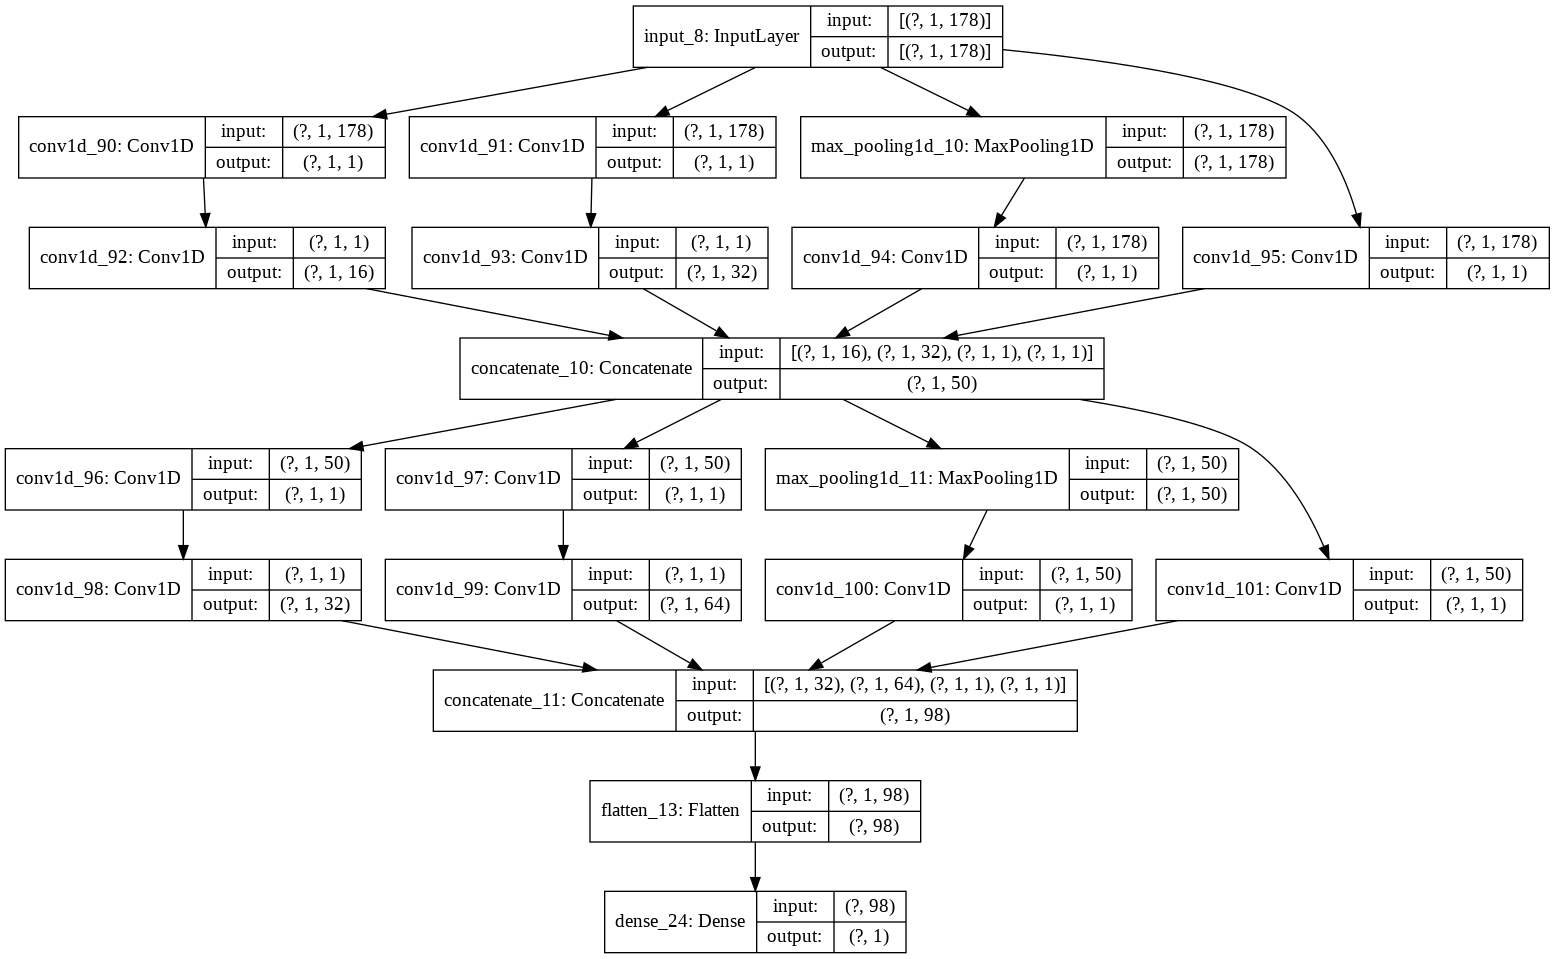

In [ ]:
plot_model(model, show_shapes=True, to_file="model.png")

Residual Network a.k.a ResNet


In [ ]:
from tensorflow.keras import activations
from tensorflow.keras.layers import add
from tensorflow.keras import activations
def residual_module(layer_in, n_filters):
  merge_input = layer_in
  if layer_in.shape[-1] != n_filters:
    merge_input = Conv1D(n_filters, 1, padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
  conv1 = Conv1D(n_filters,1, padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
  conv2 = Conv1D(n_filters, 1,padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
  layer_out = add([conv2, merge_input])
  layer_out = activations.relu(layer_out)
  return layer_out
layer = residual_module(input_layer, 32)
layer = residual_module(layer, 64)
layer0=Flatten()(layer)
layer1 = Dense(10, activation="relu")(layer0)
output= Dense(1, activation="sigmoid")(layer1)
model = Model(inputs=input_layer, outputs=output)
print(model.summary())
model.compile(optimizer="Adam", loss= "binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=15, verbose=True, validation_split=0.2, batch_size=32)
test_loss, test_acc=model.evaluate(x_test, y_test)
print(test_acc)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 178)]     0                                            
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 1, 32)        5728        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 1, 32)        1056        conv1d_31[0][0]                  
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 1, 32)        5728        input_1[0][0]                    
____________________________________________________________________________________________

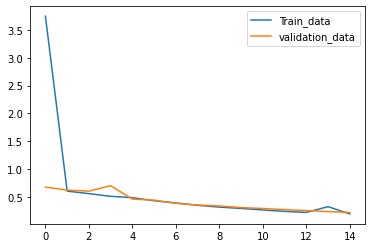

In [ ]:
plt.plot(history.history["loss"], label="Train_data")
plt.plot(history.history["val_loss"], label="validation_data")
plt.legend()
plt.show()

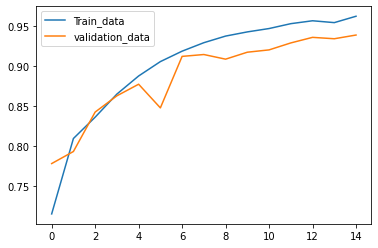

In [ ]:
plt.plot(history.history["accuracy"], label="Train_data")
plt.plot(history.history["val_accuracy"], label="validation_data")
plt.legend()
plt.show()

In [ ]:
y_pred_inception = model.predict(x_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, y_pred_inception)
area = auc(fpr, tpr)
print(y_test[2657], y_pred_inception[2657].round())
print(area)

1 [1.]
0.9663679857582613


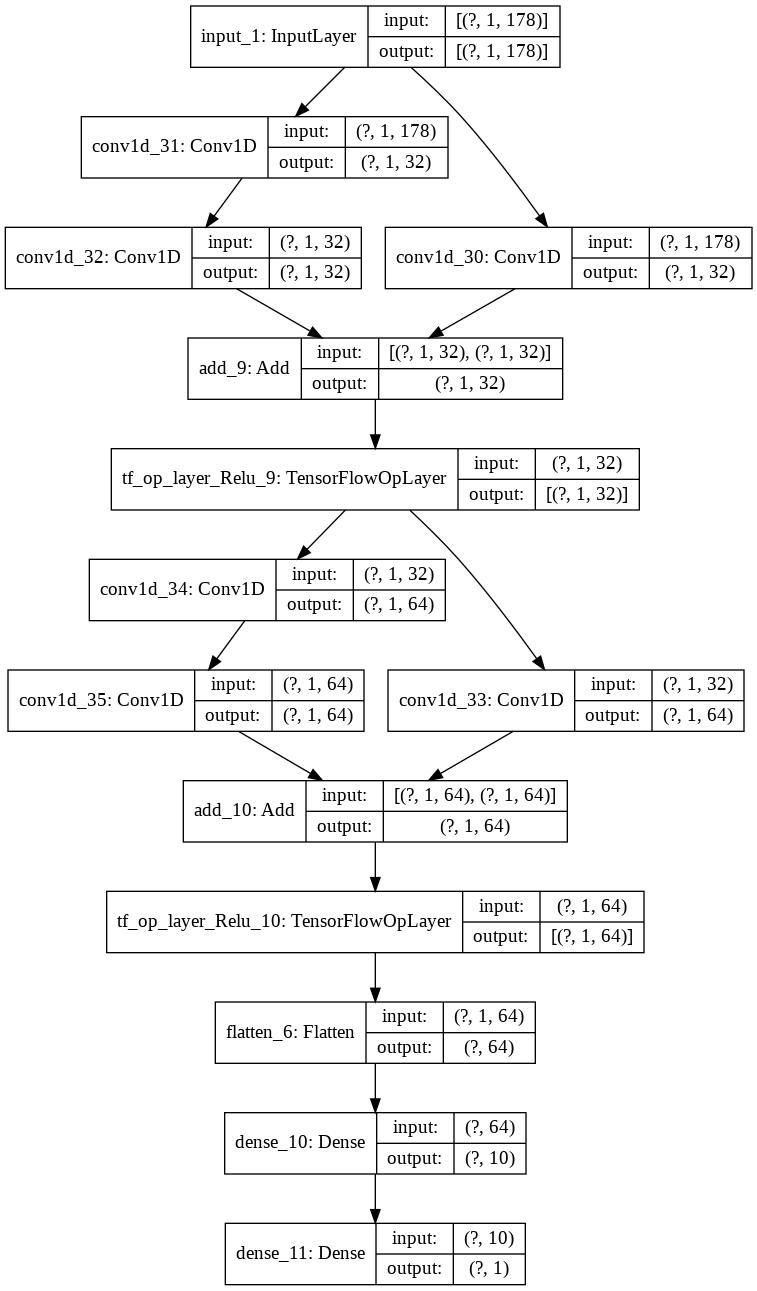

In [ ]:
plot_model(model, show_shapes=True, to_file="model.png")